In [1]:
# Nature Scientific Data Paper
# Author: Kelsey Montgomery
# Date: 20190604

In [2]:
# Dependencies
suppressMessages({library(CovariateAnalysis)
                  library(variancePartition)
                  library(BiocParallel)
                  library(data.table)
                  library(tidyverse)
                  library(synapser)
                  library(spatstat)
                  library(ggrepel)
                  library(cowplot)
                  library(biomaRt)
                  library(foreach)
                  library(future)
                  library(limma)
                  library(edgeR)
                  })

In [3]:
feature = 'genes'

In [4]:
# Directory for figure output
if(!dir.exists(feature)){
    dir.create(feature, recursive=TRUE)
}

# Process functions
downloadFile_version <- function(id , version){
  fread(synGet(id, version = version)$path, data.table = F)
}

In [5]:
# Login to Synapse with apikey - https://r-docs.synapse.org/articles/manageSynapseCredentials.html
synLogin()

Welcome, kj.benjamin!

NULL

In [6]:
param = SnowParam((availableCores()-2)/2, "SOCK", progressbar=TRUE)
register(param)

## Download metadata

In [7]:
# Download clinical metadata 
CLINICAL_ID = 'syn3354385'
clinical = downloadFile_version(CLINICAL_ID, version = 4)

# Download RNASeq metadata
METADATA_QC_DLPFC_ID = 'syn18358379' 
metadata = downloadFile_version(METADATA_QC_DLPFC_ID, version = 3)

# Join clinical and RNASeq metadata 
md = right_join(clinical, metadata, by = c("Individual ID" = "Individual_ID")) %>% 
    mutate(Dx = fct_recode(Dx, AFF_BP = "BP", AFF_BP = "AFF", Other = "undetermined", 
                           Control = "Control", SCZ = "SCZ")) %>%
    filter(Dx %in% c("Control", "SCZ"), Sex == 'XX')

# Compute read pair metrics and add Institution-Dx variable
md <- md %>%
  mutate(MappedRead_Pairs = Mapped_Reads/2) %>%
  mutate(`Institution-Dx` = paste0(`Institution`, "-", `Dx`)) %>% 
  mutate(TotalRead_Pairs = Total_Reads/2)

# Add MDS from SNPs
mds_file = paste0('/ceph/users/jbenja13/projects/sex_sz_ria/input/commonMind/',
                  'genotypes/mds/_m/CMC_MSSM-Penn-Pitt_DLPFC_QC.mds')
mds = fread(mds_file, data.table=F)
colnames(mds) = gsub('C', 'snpPC', colnames(mds))

pheno_file = paste0('/ceph/users/jbenja13/projects/sex_sz_ria/input/commonMind/', 
                    'phenotypes/combine_files/_m/CMC_phenotypes_all.csv')
pheno = read.csv(pheno_file, stringsAsFactors = F) 
genotypes = merge(pheno, mds, by.y='IID', by.x='Genotypes.Genotyping_Sample_ID') 

genotypes = genotypes %>% 
    dplyr::select("Individual_ID", starts_with("snpPC")) %>%
    rename("Individual ID"=Individual_ID)

md = md %>% left_join(genotypes, by="Individual ID") %>% distinct

md %>% dim

[1] 315  65

In [8]:
unique(md$Brain_Region)

[1] "DLPFC"

## Define covariate relationships

In [9]:
# Covariate relationships
FactorCovariates <- c('Individual ID', "Institution", "Reported Gender", "Library_Batch", 
                      "Ribozero_Batch", "Flowcell_Batch", "Dx")
ContCovariates <- c("Age of Death", "PMI (in hours)", "RIN", "Mapped_Reads", 
                    "MappedRead_Pairs", "Intragenic_Rate", "Intronic_Rate", 
                    "Intergenic_Rate", "Genes_Detected", "Expression_Profiling_Efficiency",
                    "rRNA_Rate", "Total_Reads","Percent_Aligned", "snpPC1", "snpPC2", 
                    "snpPC3", "snpPC4", "snpPC5")
# Ages over 90
md <- mutate(md, `Age of Death` = ifelse(`Age of Death` == "90+", "90", `Age of Death`))

# Find inter relation between factor covariates
covariates = md[,c(FactorCovariates,ContCovariates),drop=F]
covariates[,FactorCovariates] <- data.frame(lapply(covariates[,FactorCovariates],function(x){
  x <- sapply(x,function(y){str_replace_all(as.character(y),'[^[:alnum:]]','_')})}))
rownames(covariates) <- md$SampleID

# Convert factor covariates to factors
covariates[,FactorCovariates] = lapply(covariates[,FactorCovariates], factor)
covariates[,ContCovariates] = lapply(covariates[,ContCovariates], function(x){
  x = as.numeric(as.character(gsub('[\\,\\%]','',x)))
})

# Remove spaces
colnames(covariates) <- gsub(' ', '_', colnames(covariates))
covariates %>% dim

[1] 315  25

## Download counts

In [10]:
# Download counts (DLPFC - MSSM)
COUNT_ID = 'syn17346208'
count = downloadFile_version(COUNT_ID, version = 2) %>% data.frame()
count$transcript_id.s. = NULL

# Download gene lengths (DLPFC - MSSM)
genelen_CMC = downloadFile_version('syn17346397', version = 2) %>%
  gather(sampleID, Length, -gene_id, -`transcript_id(s)`) %>%
  group_by(gene_id) %>%
  summarise(Length = median(Length, na.rm = T)) %>%
  ungroup() %>% data.frame()

# Download counts (DLPFC - HBCC)
COUNT_ID = 'syn17894685'
count_HBCC = downloadFile_version(COUNT_ID, version = 4) %>% data.frame()
count_HBCC$transcript_id.s. = NULL

# Join HBCC and MSSM counts
count = full_join(count, count_HBCC, by = c("gene_id"))
count[1:2, 1:5]

,gene_id,MSSM_RNA_BP_PFC_2,MSSM_RNA_BP_PFC_4,MSSM_RNA_BP_PFC_5,MSSM_RNA_BP_PFC_6
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000003.14,159,113,175,117
2,ENSG00000000005.5,2,1,1,2


In [11]:
NEW.COUNTS = count %>% column_to_rownames(var='gene_id') %>% t %>%
    as.data.frame %>% rownames_to_column %>% 
    filter(rowname %in% md$SampleID) %>% 
    column_to_rownames(var="rowname") %>% t %>%
    as.data.frame
NEW.COUNTS[1:2, 1:5]

,MSSM_RNA_PFC_6,MSSM_RNA_PFC_11,MSSM_RNA_PFC_15,MSSM_RNA_PFC_16,MSSM_RNA_PFC_20
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003.14,131,226,204,256,129
ENSG00000000005.5,0,4,0,0,0


## Voom with DREAM

In [12]:
# Set covariates to adjust for from model selection
adjust.covars <- c("Dx", "RIN", "Intronic_Rate")

writeLines(paste('Using following covariates in the model:',
                 paste(adjust.covars, collapse=', '),
                 'as fixed effects and Individual_ID is chosen as random effect'))
# Post adjusted formula
random_effect <- "Individual_ID"
formula <- glue::glue("~ ", glue::glue_collapse(adjust.covars, sep = " + ")) %>% 
  glue::glue(" + (1|{random_effect})")

Using following covariates in the model: Dx, RIN, Intronic_Rate as fixed effects and Individual_ID is chosen as random effect


In [13]:
# Estimate voom weights with DREAM
geneExpr = DGEList(NEW.COUNTS, samples=covariates)

In [14]:
design0 <- model.matrix(~Dx, data=geneExpr$samples)
keep.x <- filterByExpr(geneExpr, design=design0)
geneExpr <- geneExpr[keep.x, , keep.lib.sizes=FALSE]
print(paste('There are:', sum(keep.x), 'features left!', sep=' '))

[1] "There are: 20374 features left!"


In [15]:
geneExpr = calcNormFactors(geneExpr)

In [16]:
VOOM.GENE_EXPRESSION = voomWithDreamWeights(counts = geneExpr, 
                                            formula = formula,
                                            data = covariates,
                                            save.plot = TRUE)

Memory usage to store result: > 569.8 Mb 
Dividing work into 100 chunks...


iteration: 
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100





Total: 181 s


Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”


In [17]:
save(VOOM.GENE_EXPRESSION, file=paste0(feature,'/voom.RData'))

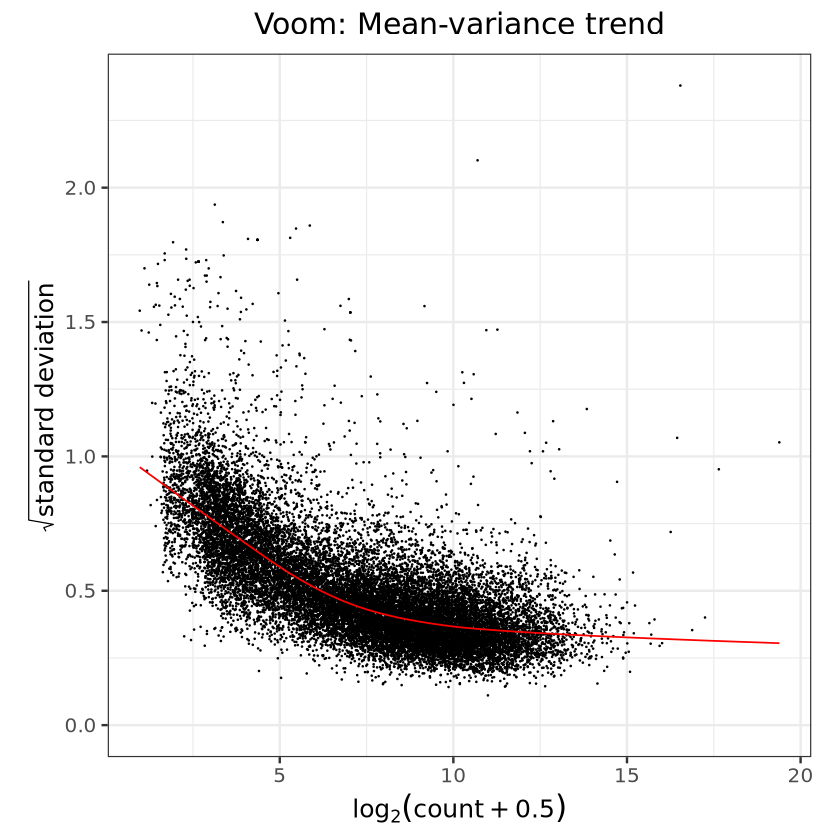

In [18]:
# How to plot a voom object if save.plot=TRUE
# Set plot generic to voom result EList
#' @export
setMethod("plot", signature(x="EList", y="missing"),
  function(x,  y, ...){
    if( is.null(x$voom.xy) || is.null(x$voom.line)){
        stop("x does not contain the trend information.\nvoom() must be run with save.plot=TRUE")
    }
    # points
    df = data.frame(x = x$voom.xy$x,
                    y = x$voom.xy$y)
    # trend line
    df.line = data.frame(x = x$voom.line$x,
                        y = x$voom.line$y)
    ggplot(df, aes(x,y)) + geom_point(size=.1) + theme_bw(15) + 
      theme(aspect.ratio=1, plot.title = element_text(hjust = 0.5)) + 
      geom_line(data=df.line, aes(x,y), color="red") + xlab(bquote(log[2](count + 0.5))) + 
      ylab(expression( sqrt("standard deviation"))) + ggtitle("Voom: Mean-variance trend") + 
      ylim(0, max(df$y))
  }
)
plot(VOOM.GENE_EXPRESSION)

In [19]:
# Fit linear model using new weights and new design
ADJUSTED.FIT = dream(exprObj = VOOM.GENE_EXPRESSION,
                     formula = formula,
                     data = covariates)

Dividing work into 100 chunks...


iteration: 
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100





Total: 279 s


In [20]:
# Get background genes 
backgroundGenes = data.frame(gene_id = rownames(NEW.COUNTS)) %>%
  mutate(id = gene_id) %>%
  separate(id, c('ensembl_gene_id','position'), sep = '\\.')

# Define biomart object
mart <- biomaRt::useMart(biomart = "ENSEMBL_MART_ENSEMBL",
                host = "uswest.ensembl.org", # Ensembl Release 99 (January 2020)
                dataset = "hsapiens_gene_ensembl")
# Query biomart
Ensemble2HGNC <- getBM(attributes = c("ensembl_gene_id", "hgnc_symbol", 
                                      "percentage_gene_gc_content", "gene_biotype", 
                                      "chromosome_name"),
                       filters = "ensembl_gene_id", 
                       values = backgroundGenes$ensembl_gene_id,
                       mart = mart)

In [21]:
options(width=200)

top <- topTable(ADJUSTED.FIT, coef="DxSCZ", number = Inf, sort.by="P") %>%
    rownameToFirstColumn('gene_id') %>% 
    left_join(backgroundGenes) %>% 
    mutate(Direction = logFC/abs(logFC),
           Direction = factor(Direction, c(-1,1), c('-1' = 'DOWN', '1' = 'UP')),
           Direction = as.character(Direction)) %>%
  left_join(Ensemble2HGNC)
top %>% head(2)

Joining, by = "gene_id"

Warning message:
“Column `gene_id` joining character vector and factor, coercing into character vector”
Joining, by = "ensembl_gene_id"



,gene_id,logFC,AveExpr,t,P.Value,adj.P.Val,z.std,ensembl_gene_id,position,Direction,hgnc_symbol,percentage_gene_gc_content,gene_biotype,chromosome_name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,ENSG00000145022.4,-0.1877720,4.365346,-6.259976,1.276224e-09,1.53519e-05,-6.070362,ENSG00000145022,4,DOWN,TCTA,53.23,protein_coding,3
2,ENSG00000173258.12,0.2891993,8.631016,6.157145,2.327019e-09,1.53519e-05,5.973160,ENSG00000173258,12,UP,ZNF483,42.33,protein_coding,9


In [22]:
top.fdr <- top %>% filter(adj.P.Val<=0.05)
top.fdr %>% dim

[1] 2555   14

In [23]:
write.table(top, file=paste0(feature, "/diffExpr_szVctl_full.txt"),
            sep='\t', row.names=FALSE, quote=FALSE)
write.table(top.fdr, file=paste0(feature, "/diffExpr_szVctl_FDR05.txt"),
            sep='\t', row.names=FALSE, quote=FALSE)